# Repeat SPRING plot, more stringent filtering on total counts (min 1000)

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Load data

In [5]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [6]:
# load obs with classifier results
adata.obs = rz.load_df('backups/obs_info_27563x10_200517_12h03.npz')

## Normalize counts

In [7]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,n_counts
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,14875.0
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,6876.0
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,4643.0
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,5972.0
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,5021.0


## Save one copy of the data to master spring directory in a SPRING-compatible format  
Upon running this notebook, the resulting 2D visualization of the data is made available for exploration interactively using the [SPRING](https://academic.oup.com/bioinformatics/article/34/7/1246/4708233) tool in a web browser. This requires saving counts in a SPRING-compatible format.  

In [41]:
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri'

In [9]:
# already done in previous notebook

# save (once), may be slow
# srz.save_counts_for_spring(adata,project_dir)

## Check how universally thresholding on 1000 umi affects different cell populations.  
Is there bias? The few cells below to convince myself that it's fine to threshold at 1000 umi.

In [10]:
# an in part1 I chose total umi threshold based on the shape of the total count histograms for each library
# for most libraries the threshold is 800
# for a few, it is lower. An initial spring plot revealed that the low count cells (<1000 umis),
# consistently with previous experience, are scattered between clusters making the plot less clean and harder
# to interpret. Before universally applying the same 1000 umi threshold to all libraries, I check
# how this affect different cell types.

CSF1Ri
10880
540.0


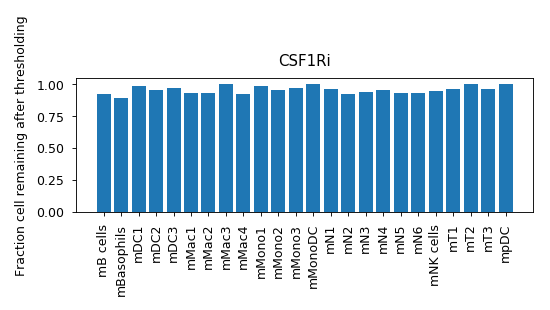

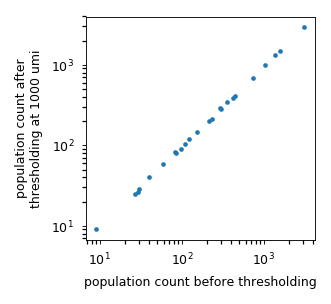

Vehicle
9673
457.0


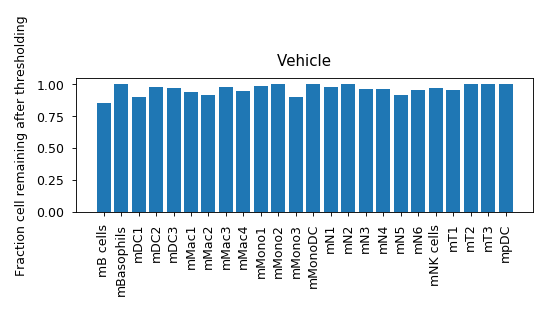

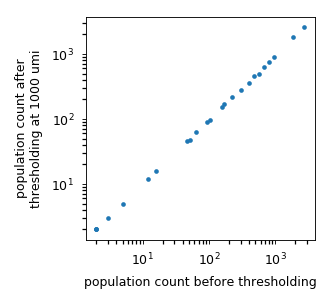

Healthy
7010
557.0


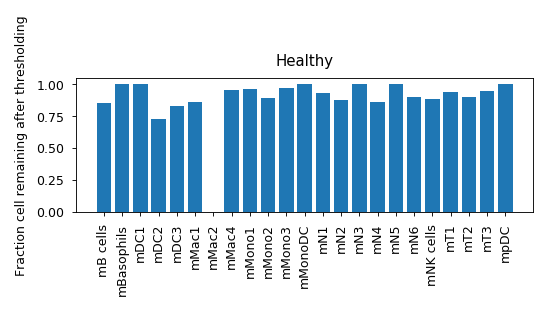

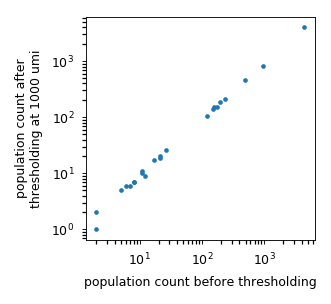

In [14]:
# taking into account all data, how does the percentage of each population in each condition change if I apply
# a universal threhsold of 1000?

#classif = 'closest_Immgen_simplified'
classif = 'closest_Zilionis2019_mouse_minor'
newts = 1000

for cond in adata.obs['condition'].unique():
    print(cond)
    
    condmask = adata.obs['condition'] == cond
    
    # counts per population for that library when the threshold is mild
    popcount = adata.obs[condmask].groupby(classif).count().iloc[:,0]
    print(popcount.sum())
    
    # difference in counts per population if applying the 1000 umi threshold
    umimask = adata.obs['total_counts']<newts
    popdif = adata.obs[condmask&umimask].groupby(classif).count().iloc[:,0]
    popdif = popdif[popcount.index]
    popdif.fillna(0,inplace=True)
    print(popdif.sum())
    
    # percentage remaining:
    rem = popcount-popdif
    pctrem = rem/popcount
    
    # barplot
    a,fig,gs = rz.startfig(10,3)
    x = np.arange(len(pctrem))
    y = pctrem
    a.bar(x,y)
    a.set_xticks(x)
    a.set_xticklabels(y.index,rotation=90)
    a.set_title(cond)
    a.set_ylabel('Fraction cell remaining after thresholding')
    plt.show()
    
    a,fig,gs = rz.startfig(5,5)
    #pseudocount to add:
    pseudocnt = 1
    a.scatter(popcount+pseudocnt,rem+pseudocnt,lw=0,s=5)
    a.set_xlabel('population count before thresholding')
    a.set_ylabel('population count after\nthresholding at %d umi'%newts)
    a.set_xscale('log')
    a.set_yscale('log')
    plt.show()

In [19]:
# the barchart above suggests that Mac2's are eliminated with more stringent thresholding. Note, that there
# is only one Mac2 before thresholding, so I neglect this population.

mask = adata.obs['condition'] == 'Healthy'
adata.obs[mask].groupby(['closest_Zilionis2019_mouse_minor']).count().iloc[:,0]

closest_Zilionis2019_mouse_minor
mB cells       963
mBasophils      16
mDC1             4
mDC2            11
mDC3             6
mMac1            7
mMac2            1
mMac4          193
mMono1         147
mMono2         171
mMono3         155
mMonoDC         25
mN1           4395
mN2            118
mN3              5
mN4              7
mN5              1
mN6             10
mNK cells      236
mT1            489
mT2             20
mT3             20
mpDC            10
Name: barcode, dtype: int64

## Data visualization in 2D. Apply the >=1000 total UMIs threshold.

### Select cells to visualize, name the plot, plotting parameters

In [20]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object

cell_mask = (adata.obs['total_counts']>=1000).values
print(cell_mask.sum(),len(cell_mask))
cdata = adata[cell_mask].copy() # all cells in this case

# chose a name for the spring subplot
plot_name = 'all_cells_w_dblt_1000umi'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.X

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

26009 27563


{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([    0,     1,     2, ..., 26006, 26007, 26008]),
 'num_pc': 20,
 'plot_name': 'all_cells_w_dblt_1000umi'}

In [21]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 10
pdict['min_cells'] = 5

pdict

{'k': 10,
 'cell_mask': array([ True,  True,  True, ..., False,  True, False]),
 'min_counts': 10,
 'min_cells': 5,
 'base_ix': array([    0,     1,     2, ..., 26006, 26007, 26008]),
 'num_pc': 20,
 'plot_name': 'all_cells_w_dblt_1000umi'}

### Gene selection

In [22]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

mt-
['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te', 'mt-Tf', 'mt-Tg', 'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2', 'mt-Tt', 'mt-Tv', 'mt-Tw', 'mt-Ty']


Rps
['Rps10', 'Rps11', 'Rps12', 'Rps12-ps3', 'Rps13', 'Rps14', 'Rps15', 'Rps15a', 'Rps16', 'Rps17', 'Rps18', 'Rps19', 'Rps19bp1', 'Rps2', 'Rps20', 'Rps21', 'Rps23', 'Rps24', 'Rps25', 'Rps26', 'Rps27', 'Rps27a', 'Rps27l', 'Rps27rt', 'Rps28', 'Rps29', 'Rps3', 'Rps3a1', 'Rps4x', 'Rps5', 'Rps6', 'Rps6ka1', 'Rps6ka2', 'Rps6ka3', 'Rps6ka4', 'Rps6ka5', 'Rps6ka6', 'Rps6kb1', 'Rps6kb2', 'Rps6kc1', 'Rps6kl1', 'Rps7', 'Rps8', 'Rps9', 'Rpsa']


Rpl
['Rpl10', 'Rpl10-ps3', 'Rpl10a', 'Rpl10l', 'Rpl11', 'Rpl12', 'Rpl13', 'Rpl13a', 'Rpl13a-ps1', 'Rpl14', 'Rpl15', 'Rpl17', 'Rpl18', 'Rpl18a', 'Rpl19', 'Rpl21', 'Rpl22', 'Rpl22l1', 'Rpl23', 'Rpl23a

In [23]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E,
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

220 genes excluded based on name
13136 genes passing abundance filter


In [24]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

28014
27983
12947 surviving genes so far


In [25]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
isexpr = np.array(E.sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[:,isexpr])

36802 genes with non-zero expression


In [26]:
# get genes above mode, i.e. any that can be considered variable
gabmod = cdata.var_names[isexpr][pdict['v_score_dict']['var_gene_mask']]
print(len(gabmod),'variable genes')

25040 variable genes


In [27]:
# update combmask:
mvar = np.in1d(cdata.var_names,gabmod)
print(mvar.sum())
combmask = combmask&mvar
print(combmask.sum(),'abundant and variable genes')

25040
12886 abundant and variable genes


In [28]:
# if filtering on correlation, get gene-gene correlation (quite slow)
corx = E[:,combmask]
print(corx.shape)
corx = srz.sparse_corrcoef(corx.T)
corx = np.array(corx)

(26009, 12886)
1.51 min.


In [29]:
# select correlation filters (largely arbitrary), as described in Klein et al. 2015
genes_at_least = 3 #at least this number of genes correlated to any other gene
corr_at_least = 0.1 #with a Pearson correlation coefficient at least this large

################################################################################

# genes passing correlation filter
cormask = (abs(corx)>corr_at_least).sum(axis=0)>genes_at_least #"more than" as one instance is the gene itself with r=1
print((~cormask).sum(), 'genes to exclude based on correlation')

# combine filter
pdict['genes_used'] = cdata.var_names[combmask][cormask]
print(len(pdict['genes_used']),'genes surviving all filters')

8885 genes to exclude based on correlation
4001 genes surviving all filters


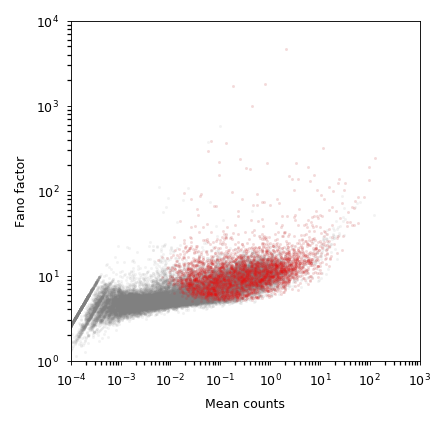

In [30]:
# plot a fano factor vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

### PCA

In [31]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(26009, 40930)
(26009, 4001)


In [32]:
# zscore (note:when applying batch correction this step is a bit more involved)
sc.pp.scale(cdata)
Z = cdata.X

/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
# find the number of non-random PCs.
# shuffle z-scores, perform PCA, get the first eigenvalue, record the number of
# observed PCs (n_non_trivial) with a eigenvalues higher than the first random eigenvalue.
# repeat 5 times, choose the smallest n_non_trivial
d = srz.find_num_pc(Z,start_pc=500,sparse=False,n=5)

calculating the first 500 observed eigenvalues...
calculating the random eigenvalues for 5 rounds of shuffling...
1 	 191 	 0.80 min.
2 	 185 	 1.36 min.
3 	 186 	 1.93 min.
4 	 190 	 2.59 min.
5 	 195 	 3.22 min.


In [34]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_

print(d['num_pc'])

185


In [35]:
# transform observed data
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(26009, 185)


### Draw graph

In [36]:
# Place the principle component data into an AnnData object to use scanpynian functions downstream

P = AnnData(P)

# get kNN graph
# ignore the error message: https://github.com/lmcinnes/umap/issues/87
k = pdict['k']
print(k, 'neighbors')
sc.pp.neighbors(P,k,use_rep='X')

# Draw force-directed graph.
# This is just to get an initial version of xy coordinates
# Nodes are further relaxed in interactive SPRING mode.
sc.tl.draw_graph(P, layout='fa')

10 neighbors
computing neighbors
    finished (0:00:23)
drawing single-cell graph using layout 'fa'
    finished (0:04:11)


### Save graph and cell coloring data for interactive exploration using the SPRING tool  
- Force layout is finished in the browser version of SPRING. It also uses forceAtlast2 (just as draw graph) but is performed on an unweighted version of the graph, therefore the discrepancies between xy coordinates obtain in the browser and by running sc.tl.draw_graph.  
- Desired column of adata.obs can be specific to color cells.

In [37]:
cdata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,n_counts
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,14875.0
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,6876.0
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,4643.0
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,5972.0
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,5021.0


In [38]:
# continuous per-cell metadata
contvars = ['total_counts','pct_counts_mito']

# categorical
catvars = ['library','mouse','condition','closest_Immgen',
           'closest_Zilionis2019_mouse_minor','closest_Immgen_simplified']

In [39]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    P.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    P.obs[catvar] = cdata.obs[catvar].astype(str).values

In [42]:
plot_name = pdict['plot_name']
print(plot_name)

# note1: the output of sc.pp.neighbors(P,k,use_rep='X') is a weighted graph.
# but it is saved as an unweighted graph for SPRING
# further clustering and any graph-based analyses are performed
# on the UNweighted graph obtained by loading graph data from the
# spring directory

# note2: at the moment of running this notebook export_spring_plot was not updated to work with
# scanpy versions higher than 1.4.4.post1. Email me at rapolas.zilionis@gmail.com if you happen
# to be running this notebook and the issue is still not fixed.



srz.export_spring_plot(P,
                       project_dir,
                       plot_name,
                       
                       # specify the normalized expression values
                       # this is solely to calculate where the default saturation
                       # of gene expression is in the interactive explorer
                       E = adata[cell_mask].X.tocsc(), # tocsc() super important here
                       gene_list = adata.var_names.values,
                       cell_groupings=catvars,
                       custom_color_tracks=contvars,
                      )

all_cells_w_dblt_1000umi
Writing subplot to /Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet/CSF1Ri/all_cells_w_dblt_1000umi/


In [43]:
# the function "srz.export_spring_plot" needs to be updated to properly save the cell filter. To do.
# for now I use a hack and save manually using the code in this cell.

subplot_dir = project_dir+'/'+plot_name + '/'
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]  
np.savetxt(subplot_dir + 'cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_dir + 'cell_filter.npy', cell_ix)

In [44]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)

In [45]:
# make an html copy of THIS notebook

moveto = project_dir+'/'+plot_name+'/'
!jupyter nbconvert part3c_spring_plot_1000_umi.ipynb
!mv part3c_spring_plot_1000_umi.html "$moveto"

[NbConvertApp] Converting notebook part3c_spring_plot_1000_umi.ipynb to html
[NbConvertApp] Writing 481506 bytes to part3c_spring_plot_1000_umi.html


In [42]:
!open "$moveto"